### 一.简介

Dropout技术在深度学习中对防止过拟合起到了很好的作用，google甚至为其申请了专利，论文《Dart:Dropouts Meet Multiple Additive Regression Trees》将dropout应用到了gbdt中，这种技术称作DART。简单来说就是在训练过程中暂时丢弃部分已生成的树，使得模型中树的贡献更加均衡（一般最先生成的树的贡献更大），防止过拟合。

### 二.流程
分两步：  

（1）在进行每一轮训练时，对当前已经生成好的$n$颗树随机丢弃掉$k$颗，对对剩下的$n-k$颗树计算其负梯度，并训练一颗新的回归树去拟合该负梯度；  

（2）执行标准化操作，由于丢掉了部分的树，所以新训练的树的预测结果其实是超出了拟合目标的，需要对其做标准化操作，对丢弃的树乘以$\frac{k}{k_+1}$的权重，对新训练的树乘以$\frac{1}{k+1}$的权重

### 三.代码实现
代码实现很简单，就直接在GBDTRegressor和GBDTClassifier上面微调即可

In [1]:
import os
os.chdir('../')
from ml_models.tree import CARTRegressor
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


"""
DART回归模型，封装到ml_models.ensemble
"""


class DARTRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10, loss='ls', huber_threshold=1e-1,
                 quantile_threshold=0.5, dropout=0.5):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param loss:表示损失函数ls表示平方误差,lae表示绝对误差,huber表示huber损失,quantile表示分位数损失
        :param huber_threshold:huber损失阈值，只有在loss=huber时生效
        :param quantile_threshold损失阈值，只有在loss=quantile时生效
        :param dropout:每个模型被dropout的概率
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTRegressor(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)
        self.loss = loss
        self.huber_threshold = huber_threshold
        self.quantile_threshold = quantile_threshold
        self.dropout = dropout
        # 记录模型权重
        self.weights = []

    def _get_gradient(self, y, y_pred):
        if self.loss == 'ls':
            return y - y_pred
        elif self.loss == 'lae':
            return (y - y_pred > 0).astype(int) * 2 - 1
        elif self.loss == 'huber':
            return np.where(np.abs(y - y_pred) > self.huber_threshold,
                            self.huber_threshold * ((y - y_pred > 0).astype(int) * 2 - 1), y - y_pred)
        elif self.loss == "quantile":
            return np.where(y - y_pred > 0, self.quantile_threshold, self.quantile_threshold - 1)

    def _dropout(self, y_pred):
        # 选择需要被dropout掉的indices
        dropout_indices = []
        no_dropout_indices = []
        for index in range(0, len(y_pred)):
            if np.random.random() <= self.dropout:
                dropout_indices.append(index)
            else:
                no_dropout_indices.append(index)
        if len(dropout_indices) == 0:
            np.random.shuffle(no_dropout_indices)
            dropout_indices.append(no_dropout_indices.pop())
        k = len(dropout_indices)
        # 调整对应的weights
        for index in dropout_indices:
            self.weights[index] *= (1.0 * k / (k + 1))
        # 返回新的pred结果以及dropout掉的数量
        y_pred_result = np.zeros_like(y_pred[0])
        for no_dropout_index in no_dropout_indices:
            y_pred_result += y_pred[no_dropout_index] * self.weights[no_dropout_index]
        return y_pred_result, k

    def fit(self, x, y):
        # 拟合第一个模型
        self.base_estimator[0].fit(x, y)
        self.weights.append(1.0)
        y_pred = [self.base_estimator[0].predict(x)]
        new_y_pred, k = self._dropout(y_pred)
        new_y = self._get_gradient(y, new_y_pred)
        for index in range(1, self.n_estimators):
            self.base_estimator[index].fit(x, new_y)
            self.weights.append(1.0 * (1 / (k + 1)))
            y_pred.append(self.base_estimator[index].predict(x))
            new_y_pred, k = self._dropout(y_pred)
            new_y = self._get_gradient(y, new_y_pred)

    def predict(self, x):
        return np.sum(
            [self.base_estimator[0].predict(x) * self.weights[0]] +
            [self.base_estimator[i].predict(x) * self.weights[i] for i in
             range(1, self.n_estimators - 1)] +
            [self.base_estimator[self.n_estimators - 1].predict(x) * self.weights[-1]]
            , axis=0)

In [2]:
data = np.linspace(1, 10, num=100)
target = np.sin(data) + np.random.random(size=100)  # 添加噪声
data = data.reshape((-1, 1))

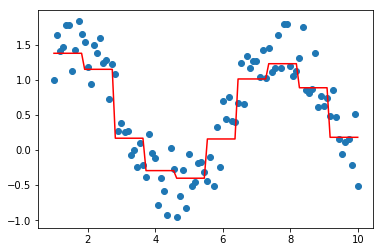

In [3]:
model = DARTRegressor(base_estimator=CARTRegressor())
model.fit(data, target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')
plt.show()

In [4]:
from ml_models import utils
"""
DART分类模型，封装到ml_models.ensemble
"""

class DARTClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10, dropout=0.5):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        :param dropout: dropout概率
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.dropout = dropout
        if self.base_estimator is None:
            # 默认使用决策树桩
            self.base_estimator = CARTRegressor(max_depth=2)
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

        # 扩展class_num组分类器
        self.expand_base_estimators = []

        # 记录权重
        self.weights = None

    def _dropout(self, y_pred_score_):
        y_pred_score_results = []
        ks = []
        for class_index in range(0, self.class_num):
            dropout_indices = []
            no_dropout_indices = []
            for index in range(0, len(y_pred_score_[class_index])):
                if np.random.random() <= self.dropout:
                    dropout_indices.append(index)
                else:
                    no_dropout_indices.append(index)
            if len(dropout_indices) == 0:
                np.random.shuffle(no_dropout_indices)
                dropout_indices.append(no_dropout_indices.pop())
            k = len(dropout_indices)
            # 调整对应的weights
            for index in dropout_indices:
                self.weights[class_index][index] *= (1.0 * k / (k + 1))
            # 返回新的pred结果以及dropout掉的数量
            y_pred_result = np.zeros_like(y_pred_score_[class_index][0])
            for no_dropout_index in no_dropout_indices:
                y_pred_result += y_pred_score_[class_index][no_dropout_index] * self.weights[class_index][
                    no_dropout_index]
            y_pred_score_results.append(y_pred_result)
            ks.append(k)
        return y_pred_score_results, ks

    def fit(self, x, y):
        # 将y转one-hot编码
        class_num = np.amax(y) + 1
        self.class_num = class_num
        y_cate = np.zeros(shape=(len(y), class_num))
        y_cate[np.arange(len(y)), y] = 1

        self.weights = [[] for _ in range(0, class_num)]

        # 扩展分类器
        self.expand_base_estimators = [copy.deepcopy(self.base_estimator) for _ in range(class_num)]

        # 拟合第一个模型
        y_pred_score_ = [[] for _ in range(0, self.class_num)]
        # TODO:并行优化
        for class_index in range(0, class_num):
            self.expand_base_estimators[class_index][0].fit(x, y_cate[:, class_index])
            y_pred_score_[class_index].append(self.expand_base_estimators[class_index][0].predict(x))
            self.weights[class_index].append(1.0)
        y_pred_result, ks = self._dropout(y_pred_score_)
        y_pred_result = np.c_[y_pred_result].T
        # 计算负梯度
        new_y = y_cate - utils.softmax(y_pred_result)
        # 训练后续模型
        for index in range(1, self.n_estimators):
            for class_index in range(0, class_num):
                self.expand_base_estimators[class_index][index].fit(x, new_y[:, class_index])
                y_pred_score_[class_index].append(self.expand_base_estimators[class_index][index].predict(x))
                self.weights[class_index].append(1.0 / (ks[class_index] + 1))
            y_pred_result, ks = self._dropout(y_pred_score_)
            y_pred_result = np.c_[y_pred_result].T
            new_y = y_cate - utils.softmax(y_pred_result)

    def predict_proba(self, x):
        # TODO:并行优化
        y_pred_score = []
        for class_index in range(0, len(self.expand_base_estimators)):
            estimator_of_index = self.expand_base_estimators[class_index]
            y_pred_score.append(
                np.sum(
                    [estimator_of_index[0].predict(x)* self.weights[class_index][0]] +
                    [self.weights[class_index][i] * estimator_of_index[i].predict(x) for i in
                     range(1, self.n_estimators - 1)] +
                    [estimator_of_index[self.n_estimators - 1].predict(x) * self.weights[class_index][-1]]
                    , axis=0)
            )
        return utils.softmax(np.c_[y_pred_score].T)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [5]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

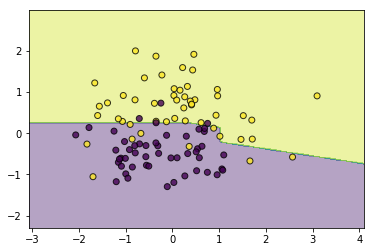

In [6]:
from ml_models.linear_model import LinearRegression
classifier = DARTClassifier(base_estimator=[LinearRegression(),LinearRegression(),LinearRegression(),CARTRegressor(max_depth=2)])
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

### 四.讨论

（1）DART其实可以看做介于随机森林和GBDT之间的一种树，当`dropout=0`时，等价于GBDT，当`dropout=1`时，等价于randomforest；   

（2）另外需要注意一下的是，当xgboost使用dart时，由于进入了随机性，会使得early stopping操作变得不稳定